# CS 5242 Homework 5

In this assignment, we are going to dive into autoencoders (AE) and variational autoencoders (VAE). AEs are powerful discriminative models while VAEs are widely used in generation tasks.

### **Submission**

ASSIGNMENT DEADLINE ⏰ : **23:59 10 Apr 2024**

Rename this file as "{StuID}_{Name}_assignment-5.ipynb" (e.g., "A0100000J_Wang-Wenjie_assignment-5.ipynb"), and submit it to Canvas. Make sure all outputs are saved in this file as we will not run any code for you. Do **not** submit any other files, especially dataset files.


### **Contact**

Feel free to reach me if you have any question about this homework.

Slack: Xiangyu Peng

Email: xiangyupeng@comp.nus.edu.sg

## Task 1: Training an autoencoder (AE)
In task 1, the goal is to train an autoencoder (AE), which consists of an encoder and a decoder. AE is capable of learning meaningful representations in the latent space, which could be used for tasks like classification. Let's see how it works.

In [32]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, hidden_dim),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.flatten(1)
        x_enc = self.encoder(x)
        x_dec = self.decoder(x_enc)
        x_recon = x_dec.reshape(B, C, H, W)
        return x_recon

# Instantiate the model
input_dim = 28 * 28
hidden_dim = 32
model = Autoencoder(input_dim, hidden_dim).to(device)

We have prepared the dataset and the AE model for you. Your task is to implement the training code and meet the following requirements:
- use mean squared error (MSE) as the loss function
- use a proper optimizer and a proper learning rate
- train the model for 10 epochs
- plot the training loss curve (at least 20 points in the curve, since we train 20 epochs)

Training Epoch: 1/10, Training Loss: 0.0003
Training Epoch: 2/10, Training Loss: 0.0001
Training Epoch: 3/10, Training Loss: 0.0001
Training Epoch: 4/10, Training Loss: 0.0001
Training Epoch: 5/10, Training Loss: 0.0001
Training Epoch: 6/10, Training Loss: 0.0001
Training Epoch: 7/10, Training Loss: 0.0001
Training Epoch: 8/10, Training Loss: 0.0001
Training Epoch: 9/10, Training Loss: 0.0001
Training Epoch: 10/10, Training Loss: 0.0001


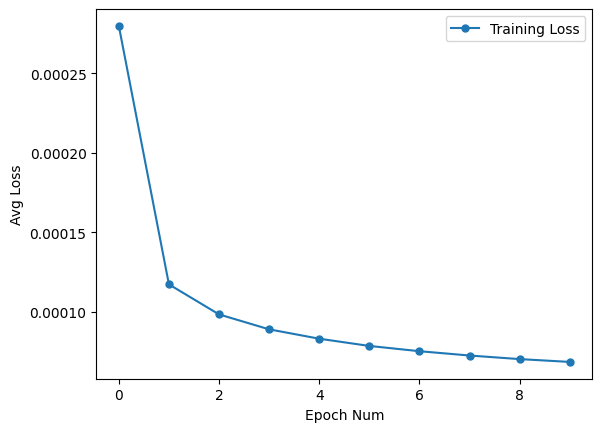

In [33]:
num_epochs = 10

# TODO: train the AE model (2 points)
##############################################
# Your code starts here
##############################################

import matplotlib.pyplot as plt
learning_rate = 0.001
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
for epoch in range(num_epochs):
  total_loss = 0
  for data in train_loader:
    image, _ = data
    image = image.to(device)
    output = model(image)
    loss = loss_function(output, image)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # losses.append(loss.item())
    total_loss += loss.item()

  avg_loss = total_loss / len(train_loader.dataset)
  losses.append(avg_loss)
  print(f'Training Epoch: {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}')
  # print(f'Training Epoch: {epoch + 1}/{num_epochs}, Training Loss: {loss.item():.4f}')
plt.plot(losses, label='Training Loss', marker='o', markersize=5)
plt.xlabel('Epoch Num')
plt.ylabel('Avg Loss')
plt.legend()
plt.show()

##############################################
# Your code ends here
##############################################

Verify your AE is well trained by visualizing reconstructed images.

Input Images:


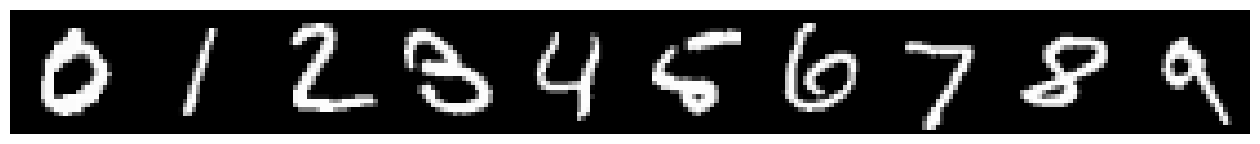

Reconstructed Images:


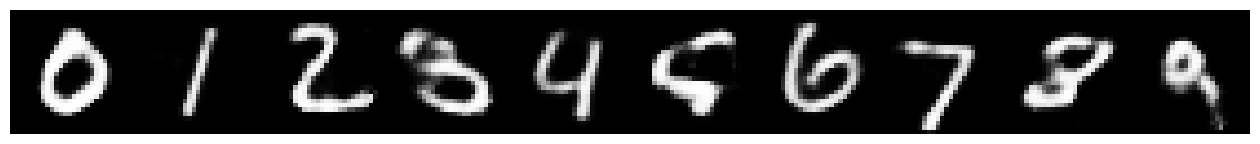

In [34]:
# Visualizing reconstructed images
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

sample_list = []
for idx_class in range(10):
    indices_i = (test_dataset.targets == idx_class).nonzero().view(-1)
    idx_sample = indices_i[0]
    sample = test_dataset[idx_sample]
    sample_list.append(sample[0])
x_orig = torch.stack(sample_list).to(device)

# Inference
model.eval()
with torch.no_grad():
    x_recon = model(x_orig)

# Plot the input and reconstructed images
imgs_orig = make_grid(x_orig, nrow=10, padding=0, normalize=True)
imgs_recon = make_grid(x_recon, nrow=10, padding=0, normalize=True)

print('Input Images:')
plt.figure(figsize=(16, 8))
plt.imshow(imgs_orig.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

print('Reconstructed Images:')
plt.figure(figsize=(16, 8))
plt.imshow(imgs_recon.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

Now we have trained an AE. Let's see how it can be used for classification. You are required to plot a [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) map of the latent representations output by the encoder. Implement the code below and follow these requirements:
- plot a 2D t-SNE map
- plot 20 samples for each class in the **test** set (i.e., 20 points for each digit from 0 to 9)
- use different colors for each digit

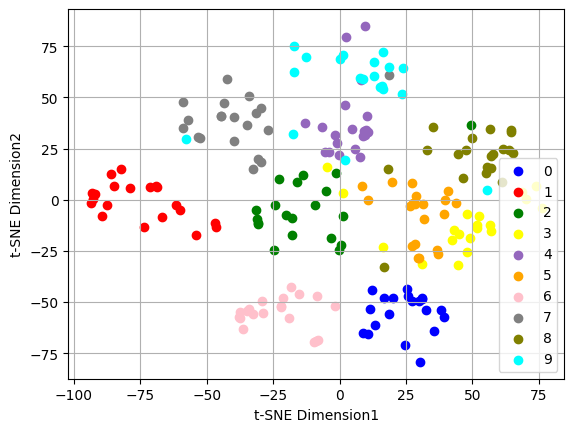

In [35]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# TODO: Plot t-SNE map (1.5 point)
##############################################
# Your code starts here
##############################################

model.eval()
latent_representations = []
true_numbers = []
with torch.no_grad():
  for data in test_loader:
    image, true_number = data
    image = image.to(device)
    true_number = true_number.to(device)
    latent_representation = model.encoder(image.flatten(1))
    # print(latent_representation)
    latent_representations.append(latent_representation.cpu().numpy())
    true_numbers.append(true_number.cpu().numpy())
latent_representations = np.concatenate(latent_representations, axis=0)
true_numbers = np.concatenate(true_numbers, axis=0)

tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_representations)
# plt.figure(figsize=(10, 10))
colors = ['blue', 'red', 'green', 'yellow', 'tab:purple', 'orange', 'pink', 'gray', 'olive', 'cyan']
for number in range(10):
  number_coordinates = np.where(true_numbers == number)[0][:20]
  plt.scatter(latent_tsne[number_coordinates, 0], latent_tsne[number_coordinates, 1], c=colors[number], label=str(number))
plt.xlabel('t-SNE Dimension1')
plt.ylabel('t-SNE Dimension2')
plt.legend()
plt.grid(True)
plt.show()

##############################################
# Your code ends here
##############################################

Can you see the separation/classification of different digits?

## Task 2: Training a variational autoencoder (VAE)
We have trained an AE in task 1, which is demonstrated to be useful for classification. However, only the encoder of AE is used. The decoder part, which is capable of reconstruction, is wasted. Can we use the decoder for generating images?

The answer is yes. But some modifications are needed to achieve this goal. The general idea is to impose a prior distribution $p(z)$ on the latent space and constrain the learned distribution $q(z|x)$ to be close to $p(z)$, so that we can gain control over the learned latent distribution. Then, we can generate images using the decoder by sampling data points from the latent distribution. Actually, this is all about what a variational autoencoder (VAE) could do.

Typically, people use the standard normal distribution as the prior latent distribution (i.e., $p(z)= N(0, I)$), which has $ \mu=0 $ and $ \sigma=I $.

In [36]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.mu = nn.Linear(256, latent_dim)
        self.log_var = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.flatten(1)

        h = self.encoder(x)

        mu, log_var = self.mu(h), self.log_var(h)
        z = self.reparameterize(mu, log_var)

        x_dec = self.decoder(z)
        x_recon = x_dec.reshape(B, C, H, W)

        return x_recon, mu, log_var

# Instantiate the model
input_dim = 28 * 28
latent_dim = 32
model = VAE(input_dim, latent_dim).to(device)

Again, We have prepared the dataset and the VAE model for you. Your task is to implement the training code and meet the following requirements:
- The loss function consists of 2 parts: 1) BinaryCrossEntropy (BCE) loss as the reconstruction loss; 2) KL divergence loss to minimize the distance between $q(z|x)$ and $p(z)$. Note that $p(z)= N(0, I)$
- use a proper optimizer and a proper learning rate
- train the model for 10 epochs
- plot the training loss curve (at least 10 points in the curve, since we train 10 epochs)

Training Epoch: 1/10, Training Loss: 178.3645
Training Epoch: 2/10, Training Loss: 129.8846
Training Epoch: 3/10, Training Loss: 118.7337
Training Epoch: 4/10, Training Loss: 113.3411
Training Epoch: 5/10, Training Loss: 110.3091
Training Epoch: 6/10, Training Loss: 108.2045
Training Epoch: 7/10, Training Loss: 106.6292
Training Epoch: 8/10, Training Loss: 105.5450
Training Epoch: 9/10, Training Loss: 104.6558
Training Epoch: 10/10, Training Loss: 103.8862


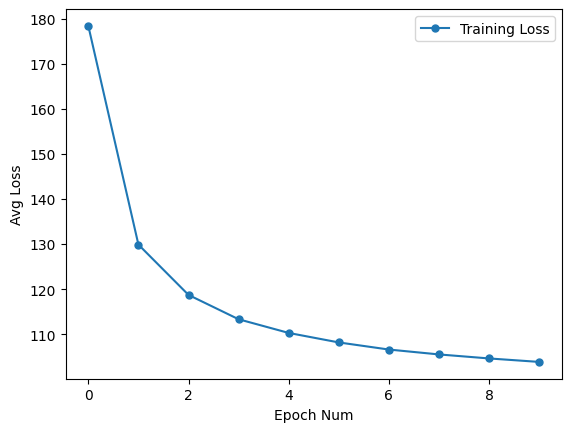

In [37]:
# TODO: train the VAE model (3 points)
##############################################
# Your code starts here
##############################################

import matplotlib.pyplot as plt

learning_rate = 0.001
latent_dim = 32
BCE_loss_function = nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
def kl_divergence_loss(u, var):
    return -0.5 * torch.sum(1 + var - u.pow(2) - var.exp())

losses = []
for epoch in range(num_epochs):
  total_loss = 0
  for data in train_loader:
    image, _ = data
    image = image.to(device)
    output, u, var = model(image)
    bce_loss = BCE_loss_function(output.view(-1, input_dim), image.view(-1, input_dim))
    kl_loss = kl_divergence_loss(u, var)
    loss = bce_loss + kl_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += abs(loss.item())
    # losses.append(loss.item())

  # print(f'Training Epoch: [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}')
  avg_loss = total_loss / len(train_loader.dataset)
  losses.append(avg_loss)
  print(f'Training Epoch: {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}')
plt.plot(losses, label='Training Loss', marker='o', markersize=5)
plt.xlabel('Epoch Num')
plt.ylabel('Avg Loss')
plt.legend()
plt.show()

##############################################
# Your code ends here
##############################################

Also, verify the sanity of the VAE model by visualizing reconstructed images.

Input Images:


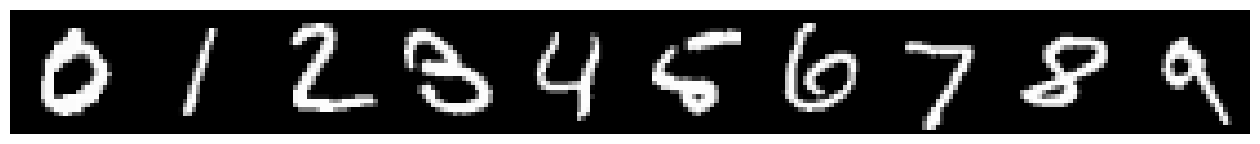

Reconstructed Images:


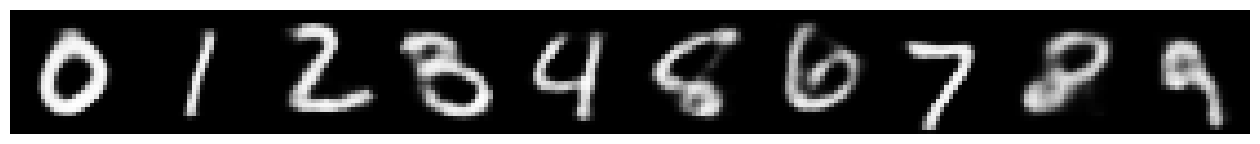

In [38]:
# Visualizing reconstructed images
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

sample_list = []
for idx_class in range(10):
    indices_i = (test_dataset.targets == idx_class).nonzero().view(-1)
    idx_sample = indices_i[0]
    sample = test_dataset[idx_sample]
    sample_list.append(sample[0])
x_orig = torch.stack(sample_list).to(device)

# Inference
model.eval()
with torch.no_grad():
    x_recon, mu, log_var = model(x_orig)

# Plot the input and reconstructed images
imgs_orig = make_grid(x_orig, nrow=10, padding=0, normalize=True)
imgs_recon = make_grid(x_recon, nrow=10, padding=0, normalize=True)

print('Input Images:')
plt.figure(figsize=(16, 8))
plt.imshow(imgs_orig.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

print('Reconstructed Images:')
plt.figure(figsize=(16, 8))
plt.imshow(imgs_recon.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

Now we have trained a VAE. Let's first check its latent distribution like we do for AE. You are required to plot a [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) map of the latent representations output by the VAE encoder. Implement the code below and follow these requirements:
- plot a 2D t-SNE map
- plot 20 samples for each class in the **test** set (i.e., 20 points for each digit from 0 to 9)
- use different colors for each digit

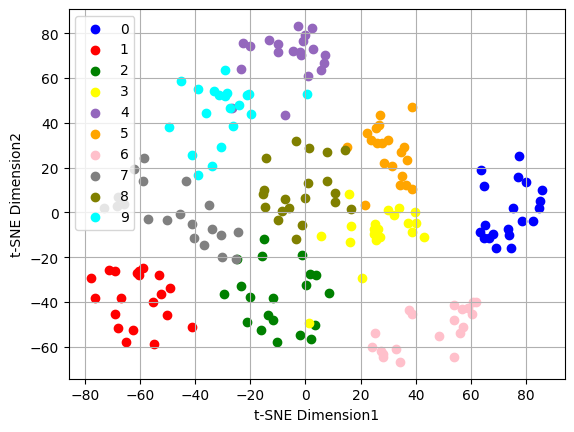

In [39]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# TODO: Plot t-SNE map (1.5 point)
##############################################
# Your code starts here
##############################################

model.eval()
latent_representations = []
true_numbers = []
with torch.no_grad():
  for data in test_loader:
    image, true_number = data
    image = image.to(device)
    true_number = true_number.to(device)
    output, u, _ = model(image)
    # print(u)
    # print(output)
    # latent_representations.append(output.cpu().numpy())
    latent_representations.append(u.cpu().numpy())
    true_numbers.append(true_number.cpu().numpy())
latent_representations = np.concatenate(latent_representations, axis=0)
true_numbers = np.concatenate(true_numbers, axis=0)

tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_representations)
# plt.figure(figsize=(10, 10))
colors = ['blue', 'red', 'green', 'yellow', 'tab:purple', 'orange', 'pink', 'gray', 'olive', 'cyan']
for number in range(10):
  number_coordinates = np.where(true_numbers == number)[0][:20]
  plt.scatter(latent_tsne[number_coordinates, 0], latent_tsne[number_coordinates, 1], c=colors[number], label=str(number))
plt.xlabel('t-SNE Dimension1')
plt.ylabel('t-SNE Dimension2')
plt.legend()
plt.grid(True)
plt.show()

##############################################
# Your code ends here
##############################################

Finally, we are able to generate images using the decoder of the VAE by sampling data points from $p(z)$. Implement the code below and meet these requirements:
- sample 10 data points from $p(z)$
- show them 5 images in a row, 2 rows in total
- at least one image should be recognized as a digit

Generated Images:


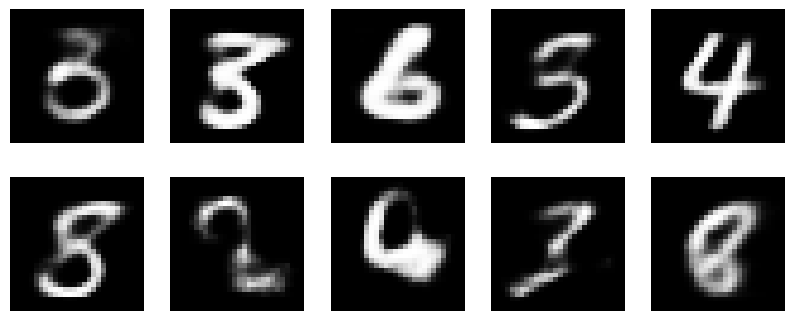

In [44]:
# TODO: generate digits using the decoder of VAE (1 point)
##############################################
# Your code starts here
##############################################

model.eval()
with torch.no_grad():
  chosen_samples = torch.randn(10, latent_dim).to(device)
with torch.no_grad():
  generated_images = model.decoder(chosen_samples).cpu()

print('Generated Images:')
plt.figure(figsize=(10, 4))
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.imshow(generated_images[i].view(28, 28), cmap='gray')
  plt.axis('off')
plt.show()

##############################################
# Your code ends here
##############################################

Open question: We can now generate digits by sampling from the latent distribution. But we cannot control which digit to generate. Do you have any idea about how can we manage to generate any digit we want?

In [41]:
# TODO: Your answer here (1 point)

To generate a specific number, we could perhaps expand the input by taking as input a number in addition to an image during training, concatenating a one-hot encoding of the desired number with a latent vector sampled from the standard normal distribution and passing it to the decoder to generate the corresponding image, using "conditional generation" to generate the specific number. Besides, during training, we might also need to make the loss function take into account both image and numbers, so that the model learns to decode the latent vector to a specific number.